In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, classification_report, 
ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, PredictionErrorDisplay, make_scorer)
from sklearn.utils.discovery import all_displays
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from pyrcn.echo_state_network import ESNClassifier

from scipy.stats import fisher_exact

from keras.models import Sequential
from keras.layers import LSTM, Dense

import torch

import json

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/michael/Documents/MA Stats/STAT 8090/final dataset/full dataset.csv')
data['ipo_date'] = pd.to_datetime(data['ipo_date'])
data = data.sort_values(by='ipo_date')
data.head()

,Symbol,Company_Name,Exchange,Orig_Range_Low,Orig_Range_High,Price,Shares,Offer_Amount,ipo_date,IPO_Year,...,plustwo_volume_pct,plusthree_change_pct,plusthree_volume_pct,plus90_change_pct,plus90_volume_pct,plus180_change_pct,plus180_volume_pct,d1_d180,d1_pop,d1_d180_pre_price
772,BOX,Box,NYSE,11.0,13.0,14.0,12500000,175000000,2015-01-23,2015,...,0.403792,-0.055276,0.273560,-0.000547,0.045112,-0.013056,0.234416,0,1,1
771,ASND,Ascendis Pharma,Nasdaq,16.0,18.0,18.0,6000000,108000000,2015-01-28,2015,...,0.024383,-0.002626,0.011633,-0.061760,0.021800,-0.058990,0.044250,1,1,1
769,SHAK,Shake Shack,NYSE,17.0,19.0,21.0,5000000,105000000,2015-01-30,2015,...,0.273360,0.020828,0.144520,0.003064,0.103760,0.142043,0.274520,1,1,1
770,ONCE,Spark Therapeutics,Nasdaq,19.0,21.0,23.0,7000000,161000000,2015-01-30,2015,...,0.039350,-0.003979,0.028890,-0.037964,0.039806,0.004957,0.091324,1,0,1
768,NVTA,InVitae,NYSE,13.0,15.0,16.0,6350000,101600000,2015-02-12,2015,...,0.037796,0.047458,0.043847,-0.000803,0.031970,0.011261,0.053750,0,1,1


In [3]:
with open('/Users/michael/Documents/MA Stats/STAT 8090/Code Files/exchange.json','r') as f:
    exchange = json.load(f)

In [4]:
with open('/Users/michael/Documents/MA Stats/STAT 8090/Code Files/sector.json','r') as f:
    sector = json.load(f)

In [5]:
with open('/Users/michael/Documents/MA Stats/STAT 8090/Code Files/industry.json','r') as f:
    industry = json.load(f)

In [6]:
data['Exchange'] = data['Exchange'].replace(exchange)
data['Sector'] = data['Sector'].replace(sector)
data['Industry'] = data['Industry'].replace(industry)

In [7]:
data = data.drop(columns=['Symbol', 'Company_Name', 'ipo_date', 'Country_HQ', 'Pitchbook_Number',
                          'Orig_Range_Low', 'Orig_Range_High', 'Year_Founded', 'Raised_to_IPO',
                          'ipo_date_open','ipo_date_close','ipo_date_volume','plusone_open','plusone_close',
                          'plusone_volume','plustwo_open','plustwo_close','plustwo_volume','plusthree_open','plusthree_close',
                          'plusthree_volume','plus90_open','plus90_close','plus90_volume','plus180_open','plus180_close',
                          'plus180_volume','day_one_bump','ipo_date_change_pct','ipo_date_volume_pct','plusone_change_pct',
                          'plusone_volume_pct','plustwo_change_pct','plustwo_volume_pct','plusthree_change_pct',
                          'plusthree_volume_pct','plus90_change_pct','plus90_volume_pct','plus180_change_pct','plus180_volume_pct',
                          'd1_d180', 'd1_d180_pre_price'])

In [8]:
data.head()

,Exchange,Price,Shares,Offer_Amount,IPO_Year,Years_to_IPO,Price_Low_Delta,Price_High_Delta,Sector,Industry,...,market_min5,market_min4,market_min3,market_min2,market_min1,market_min0,sent_negative,sent_neutral,sent_positive,d1_pop
772,0,14.0,12500000,175000000,2015,10,0.272727,0.076923,8,136,...,10840.400000,10926.733330,10471.36522,10911.726320,10818.236360,10679.23500,5,15,0,1
771,1,18.0,6000000,108000000,2015,8,0.125000,0.000000,5,65,...,4464.830476,4551.584762,4403.23000,4687.702632,4732.700909,4673.70150,0,0,0,1
769,0,21.0,5000000,105000000,2015,11,0.235294,0.105263,1,26,...,10840.400000,10926.733330,10471.36522,10911.726320,10818.236360,10679.23500,1,1,0,1
770,1,23.0,7000000,161000000,2015,2,0.210526,0.095238,5,65,...,4464.830476,4551.584762,4403.23000,4687.702632,4732.700909,4673.70150,0,0,0,0
768,0,16.0,6350000,101600000,2015,5,0.230769,0.066667,5,66,...,10926.733330,10471.365220,10911.72632,10818.236360,10679.235000,10969.93684,0,0,0,1


In [9]:
split_index = int(0.7 * len(data))

X = data.drop(columns=['d1_pop'])
y = data['d1_pop']

X['Exchange'] = X['Exchange'].astype('int')
X['Sector'] = X['Sector'].astype('int')
X['Industry'] = X['Industry'].astype('int')

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# under_sampler = RandomUnderSampler()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)

# X_train, y_train = under_sampler.fit_resample(X_train, y_train)

# unique_values = set(X_train['Industry'])

# # Check if at least one sample from each unique value is present in the training set
# for value in unique_values:
#     if value not in X_train['Industry'].unique():
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
#         break

#### Long Short-Term Memory (LSTM):

In [10]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [11]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train.shape[1])))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train, epochs=500, batch_size=32, validation_data=(X_test_reshaped, y_test))

Epoch 1/500
17/17 [==============================] - 1s 11ms/step - loss: 0.7096 - accuracy: 0.3789 - val_loss: 0.5957 - val_accuracy: 0.7026
Epoch 2/500
17/17 [==============================] - 0s 2ms/step - loss: 0.6377 - accuracy: 0.6728 - val_loss: 0.5749 - val_accuracy: 0.7500
Epoch 3/500
17/17 [==============================] - 0s 2ms/step - loss: 0.6345 - accuracy: 0.6673 - val_loss: 0.5985 - val_accuracy: 0.7500
Epoch 4/500
17/17 [==============================] - 0s 2ms/step - loss: 0.6477 - accuracy: 0.6673 - val_loss: 0.6096 - val_accuracy: 0.7500
Epoch 5/500
17/17 [==============================] - 0s 2ms/step - loss: 0.6266 - accuracy: 0.6673 - val_loss: 0.5664 - val_accuracy: 0.7500
Epoch 6/500
17/17 [==============================] - 0s 1ms/step - loss: 0.6456 - accuracy: 0.6673 - val_loss: 0.6060 - val_accuracy: 0.7500
Epoch 7/500
17/17 [==============================] - 0s 1ms/step - loss: 0.6405 - accuracy: 0.6673 - val_loss: 0.5908 - val_accuracy: 0.7500
Epoch 8/500


In [12]:
_, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Accuracy:", accuracy)

y_pred_probs = model.predict(X_test_reshaped)

y_pred = (y_pred_probs > 0.5).astype(int)

8/8 [==============================] - 0s 553us/step - loss: 0.5692 - accuracy: 0.7371
Accuracy: 0.7370689511299133
8/8 [==============================] - 0s 587us/step


In [13]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
cm

Confusion Matrix:


array([[  2,  56],
       [  5, 169]])

In [14]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (0.2278170791638439, 6.396332895230477)
p-value for Odds Ratio: 1.0


In [15]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.03      0.06        58
           1       0.75      0.97      0.85       174

    accuracy                           0.74       232
   macro avg       0.52      0.50      0.45       232
weighted avg       0.63      0.74      0.65       232



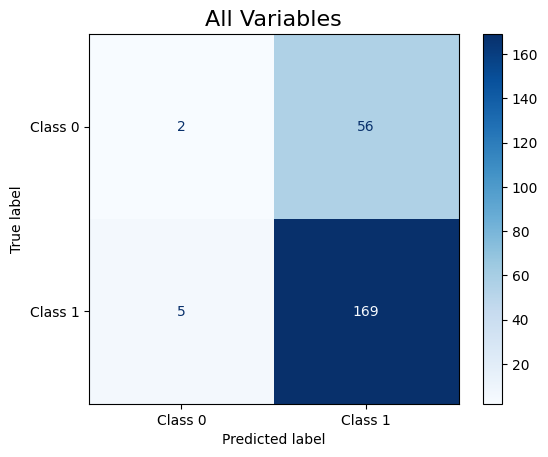

In [16]:
class_labels = ['Class 0', 'Class 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_lstm_1.png', dpi=300, bbox_inches="tight")
plt.show()

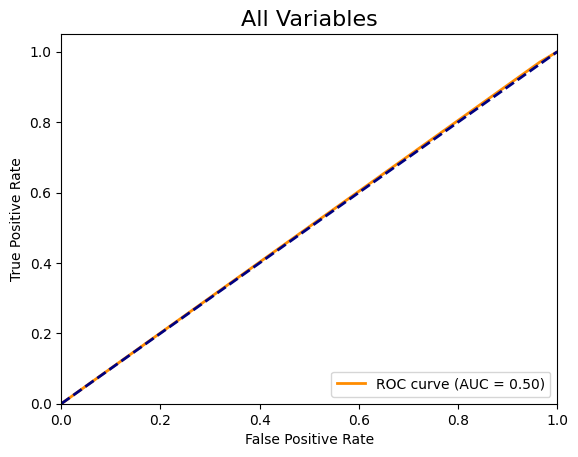

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Variables', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_lstm_1.png', dpi=300, bbox_inches="tight")
plt.show()

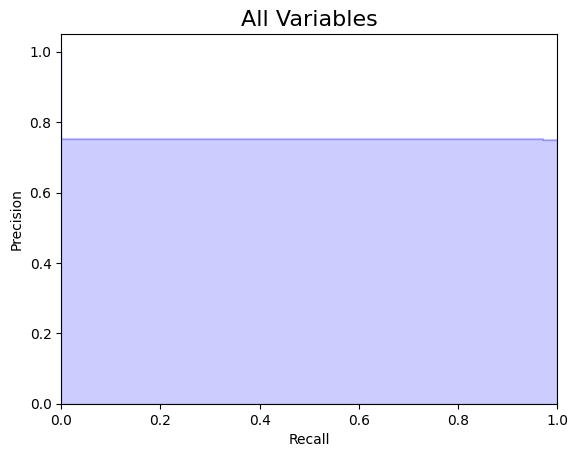

In [18]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_lstm_1.png', dpi=300, bbox_inches="tight")
plt.show()

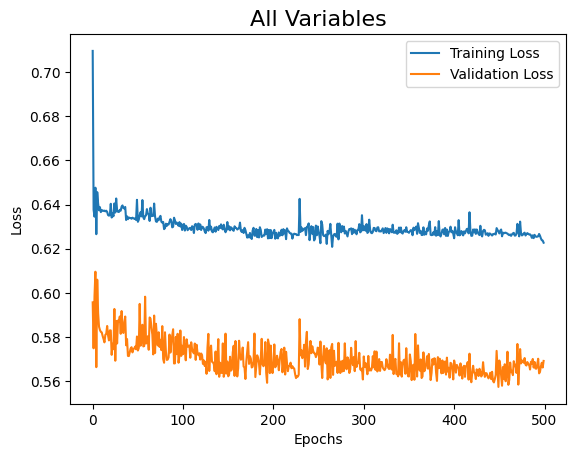

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('All Variables', fontsize=16)
plt.legend()
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/epochloss_lstm_1.png', dpi=300, bbox_inches="tight")
plt.show()

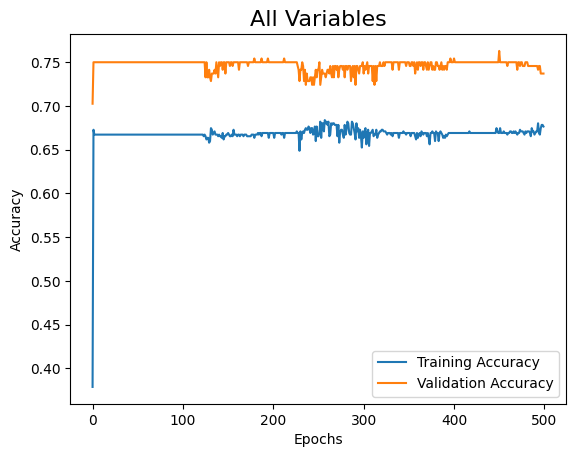

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('All Variables', fontsize=16)
plt.legend()
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/epochaccuracy_lstm_1.png', dpi=300, bbox_inches="tight")
plt.show()

## Feature Importance Models

In [21]:
model = RandomForestClassifier()
model.fit(X, y)

feature_importance = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [22]:
fi = feature_importance[feature_importance['importance'] >= 0.01]
fi = fi.index.tolist()

In [23]:
fi_data = X[fi]

In [24]:
fi_data.head()

,Price_High_Delta,Price_Low_Delta,raise_to_ipo_ratio,Offer_Amount,Shares,Price,Years_to_IPO,multi_round_investors,completed_rounds_to_ipo,Venture Capital,...,Venture_Capital_Round,Private Equity,market_min1,market_min3,market_min0,Corporation,market_min4,market_min6,ipo_same_day,market_min5
772,0.076923,0.272727,0.245122,175000000,12500000,14.0,10,33,13,68,...,10,5,10818.236360,10471.36522,10679.23500,5,10926.733330,10978.972730,1,10840.400000
771,0.000000,0.125000,0.495549,108000000,6000000,18.0,8,16,3,19,...,2,2,4732.700909,4403.23000,4673.70150,1,4551.584762,4434.125909,0,4464.830476
769,0.105263,0.235294,1.075269,105000000,5000000,21.0,11,6,3,2,...,0,4,10818.236360,10471.36522,10679.23500,0,10926.733330,10978.972730,4,10840.400000
770,0.095238,0.210526,0.569952,161000000,7000000,23.0,2,8,4,6,...,2,0,4732.700909,4403.23000,4673.70150,0,4551.584762,4434.125909,4,4464.830476
768,0.066667,0.230769,0.338678,101600000,6350000,16.0,5,15,8,20,...,6,0,10679.235000,10911.72632,10969.93684,8,10471.365220,10840.400000,1,10926.733330


In [25]:
split_index = int(0.7 * len(fi_data))

X_train = fi_data.iloc[:split_index]
X_test = fi_data.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [26]:
# X_train, X_test, y_train, y_test = train_test_split(fi_data, y, test_size=0.3, random_state=8090)

# under_sampler = RandomUnderSampler()

# X_train, y_train = under_sampler.fit_resample(X_train, y_train)

# unique_values = set(X_train['Industry'])

# # Check if at least one sample from each unique value is present in the training set
# for value in unique_values:
#     if value not in X_train['Industry'].unique():
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
#         break

### LSTM Model

In [27]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [28]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train.shape[1])))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #check loss function

history = model.fit(X_train_reshaped, y_train, epochs=500, batch_size=32, validation_data=(X_test_reshaped, y_test))

Epoch 1/500
17/17 [==============================] - 1s 10ms/step - loss: 0.6574 - accuracy: 0.6673 - val_loss: 0.6281 - val_accuracy: 0.7500
Epoch 2/500
17/17 [==============================] - 0s 2ms/step - loss: 0.6500 - accuracy: 0.6673 - val_loss: 0.6124 - val_accuracy: 0.7500
Epoch 3/500
17/17 [==============================] - 0s 2ms/step - loss: 0.6435 - accuracy: 0.6673 - val_loss: 0.6026 - val_accuracy: 0.7500
Epoch 4/500
17/17 [==============================] - 0s 1ms/step - loss: 0.6402 - accuracy: 0.6673 - val_loss: 0.5922 - val_accuracy: 0.7500
Epoch 5/500
17/17 [==============================] - 0s 2ms/step - loss: 0.6380 - accuracy: 0.6673 - val_loss: 0.5863 - val_accuracy: 0.7500
Epoch 6/500
17/17 [==============================] - 0s 1ms/step - loss: 0.6350 - accuracy: 0.6673 - val_loss: 0.5817 - val_accuracy: 0.7500
Epoch 7/500
17/17 [==============================] - 0s 1ms/step - loss: 0.6357 - accuracy: 0.6673 - val_loss: 0.5847 - val_accuracy: 0.7500
Epoch 8/500


In [29]:
_, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Accuracy:", accuracy)

y_pred_probs = model.predict(X_test_reshaped)

y_pred = (y_pred_probs > 0.5).astype(int)

8/8 [==============================] - 0s 494us/step - loss: 0.5789 - accuracy: 0.7500
Accuracy: 0.75
8/8 [==============================] - 0s 620us/step


In [30]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
cm

Confusion Matrix:


array([[  0,  58],
       [  0, 174]])

In [31]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (nan, nan)
p-value for Odds Ratio: 1.0


In [32]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.75      1.00      0.86       174

    accuracy                           0.75       232
   macro avg       0.38      0.50      0.43       232
weighted avg       0.56      0.75      0.64       232



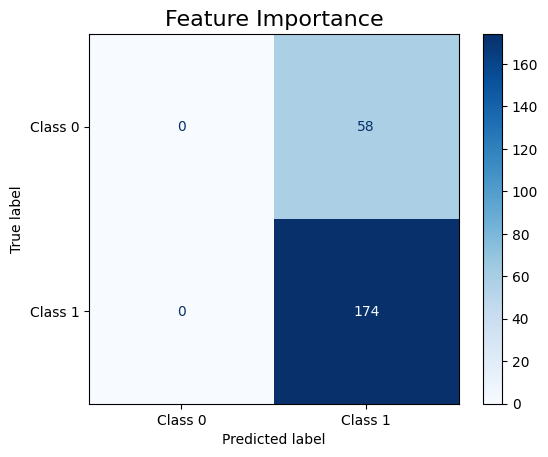

In [33]:
class_labels = ['Class 0', 'Class 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_lstm_1_fi.png', dpi=300, bbox_inches="tight")
plt.show()

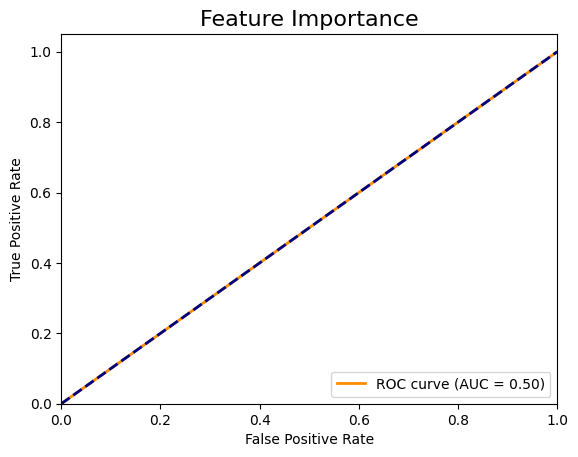

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Feature Importance', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_lstm_1_fi.png', dpi=300, bbox_inches="tight")
plt.show()

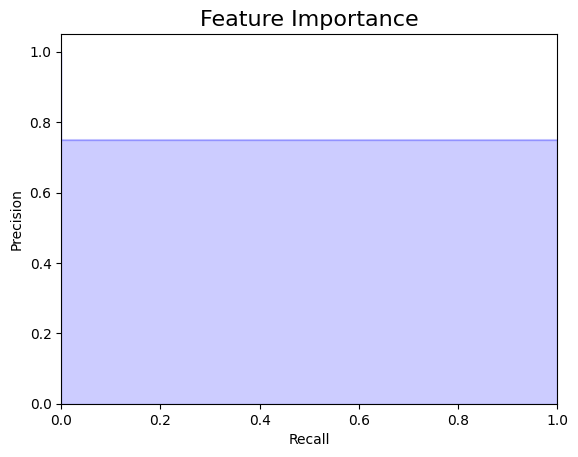

In [35]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_lstm_1_fi.png', dpi=300, bbox_inches="tight")
plt.show()

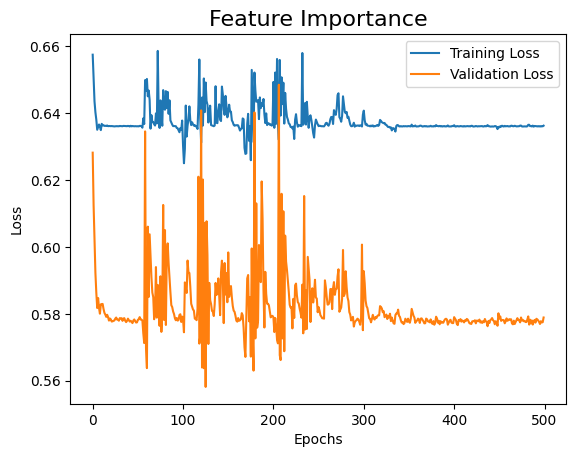

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Feature Importance', fontsize=16)
plt.legend()
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/epochloss_lstm_1_fi.png', dpi=300, bbox_inches="tight")
plt.show()

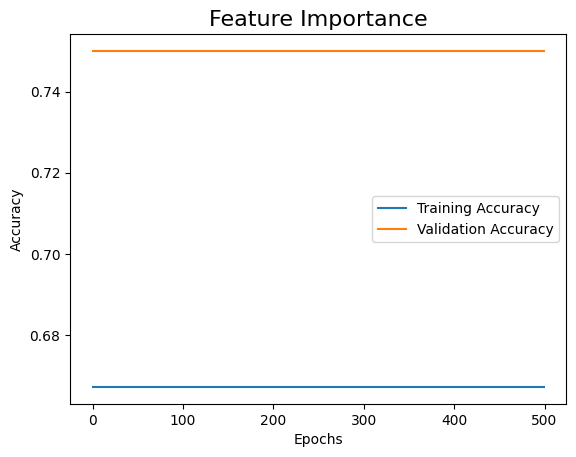

In [37]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Feature Importance', fontsize=16)
plt.legend()
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/epochaccuracy_lstm_1_fi.png', dpi=300, bbox_inches="tight")
plt.show()

---
#### End of Notebook